# Data Analysis-- Supervised Learning
* Created on Mon Sep. 29 2021 by Shangying Wang
* Last Modified: April 6, 2023
* this code is used for prediction of the phenotypes from the combinatory motifs
* This code uses the convolutional neural network and LSTM.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import csv
import os
import matplotlib.pyplot as plt
from platform import python_version
print(python_version())

2023-04-06 16:39:43.110550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 16:39:44.628952: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


3.10.10


In [2]:
from tensorflow.keras.optimizers import SGD, Adam
from keras import layers,Sequential
from keras.layers import Lambda
from keras.layers import Input, Dense, Dropout, Flatten, Average, BatchNormalization, LSTM, TimeDistributed
from tensorflow.keras.layers import Conv1D,MaxPool1D, concatenate
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.initializers import RandomNormal,HeNormal,GlorotNormal,HeUniform,LecunNormal,LecunUniform,Orthogonal
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from itertools import product
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
print(tf.__version__)

2.12.0


# For arrayed data analysis

## Load data from csv file
- CSV files available at https://www.science.org/doi/suppl/10.1126/science.abq0225/suppl_file/science.abq0225_data_s1_to_s3.zip
- Change schema to match version used in original commits
- Change motif values to match those used in original commits (i.e., change 17 to 14)

In [3]:
tf.keras.utils.set_random_seed(1)
train_data=pd.read_csv('science.abq0225_data_s2.csv',encoding= 'unicode_escape',sep=',')
test_data=pd.read_csv('science.abq0225_data_s3.csv',encoding= 'unicode_escape',sep=',')
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)
rename_dict = {'Initial CAR T Cell Number': 'Cell Number',
               'motif i': 'motif',
               'motif j': 'motif.1',
               'motif k': 'motif.2',
               'motif l': 'motif.3',
               'motif m': 'motif.4',
               'Cytotoxicity (Nalm 6 Survival)': 'Nalm 6 Cytotoxicity',
               'Stemness (% IL7Ra+ KLRG1-)': 'IL7RaKLRG1 stemness'}
train_data.rename(columns=rename_dict, inplace=True)
test_data.rename(columns=rename_dict, inplace=True)
train_data.drop([train_data.columns[7]], axis=1, inplace=True)
test_data.drop([test_data.columns[7]], axis=1, inplace=True)
train_data.replace(17, 14, inplace=True)
test_data.replace(17, 14, inplace=True)
test_data

,Cell Number,motif,motif.1,motif.2,motif.3,motif.4,Nalm 6 Cytotoxicity,IL7RaKLRG1 stemness
0,4078,8,9,2,14,0,0.473548,24.10
1,2150,2,14,0,0,0,0.551460,7.34
2,2814,8,2,11,14,0,0.691060,15.10
3,7224,8,11,11,14,0,0.720755,8.96
4,3205,8,12,8,14,0,0.520676,13.40
5,3685,10,6,3,14,0,0.528674,20.30
6,2885,4,4,14,0,0,0.350036,8.98
7,1595,11,10,9,14,0,0.112309,38.80
8,1197,10,10,1,14,0,0.050364,35.60
9,2748,8,3,2,14,0,0.708795,24.00


In [4]:
#data statistics
all_data = pd.concat([test_data, train_data])
max_cell=max(all_data['Cell Number'])
all_data['Cell Number']=all_data['Cell Number']/max_cell
train_data['Cell Number']=train_data['Cell Number']/max_cell
test_data['Cell Number']=test_data['Cell Number']/max_cell
stats_df = all_data.describe()
stats_df

,Cell Number,motif,motif.1,motif.2,motif.3,motif.4,Nalm 6 Cytotoxicity,IL7RaKLRG1 stemness
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,0.255184,7.252033,6.926829,7.300813,12.475610,0.739837,0.615778,18.636626
std,0.210155,3.910412,3.815480,3.995783,4.147954,3.138536,0.253641,8.121087
min,0.003385,1.000000,1.000000,0.000000,0.000000,0.000000,0.002313,4.490000
25%,0.103734,3.000000,3.000000,3.000000,14.000000,0.000000,0.431323,12.500000
50%,0.194125,8.000000,8.000000,8.000000,14.000000,0.000000,0.655914,16.750000
75%,0.324693,11.000000,10.000000,11.000000,14.000000,0.000000,0.820133,23.050000
max,1.000000,13.000000,14.000000,14.000000,14.000000,14.000000,1.197448,46.200000


In [5]:
skew_vals1=all_data['Nalm 6 Cytotoxicity'].skew()
skew_vals1

-0.24443600883940617

In [6]:
skew_vals2=all_data['IL7RaKLRG1 stemness'].skew()
skew_vals2

0.9456903661932705

Text(0.5, 1.0, 'after np.log1p')

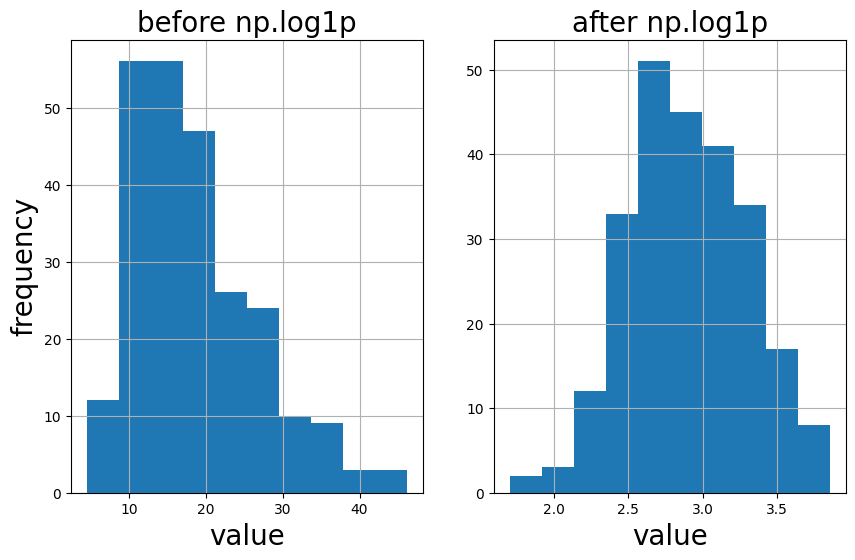

In [7]:
plt.figure(figsize=[10,20])
pheno=['IL7RaKLRG1 stemness']
new_data = all_data.copy()
pp=0
plt.subplot(3,2,1)
new_data[pheno[pp]].hist(bins=10)
plt.xlabel('value', fontsize=20)
plt.ylabel('frequency', fontsize=20)
plt.title('before np.log1p', fontsize=20)

plt.subplot(3,2,2)
new_data[pheno[pp]]=new_data[pheno[pp]].apply(np.log1p)
new_data[pheno[pp]].hist(bins=10)
plt.xlabel('value', fontsize=20)
#plt.ylabel('frequency', fontsize=20)
plt.title('after np.log1p', fontsize=20)

In [8]:
skew_vals2=new_data['IL7RaKLRG1 stemness'].skew()
skew_vals2

0.03784244019300669

In [9]:
train_data['IL7RaKLRG1 stemness'] = train_data['IL7RaKLRG1 stemness'].apply(np.log1p)
test_data['IL7RaKLRG1 stemness'] = test_data['IL7RaKLRG1 stemness'].apply(np.log1p)

In [10]:
stats_df = train_data.describe()
stats_df

,Cell Number,motif,motif.1,motif.2,motif.3,motif.4,Nalm 6 Cytotoxicity,IL7RaKLRG1 stemness
count,221.000000,221.00000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000
mean,0.257121,7.20362,6.791855,7.371041,12.656109,0.760181,0.628467,2.894458
std,0.211839,3.94959,3.800972,3.905459,3.898639,3.179687,0.252597,0.397382
min,0.003385,1.00000,1.000000,0.000000,0.000000,0.000000,0.004702,1.702928
25%,0.098971,3.00000,3.000000,3.000000,14.000000,0.000000,0.439604,2.602690
50%,0.209824,8.00000,8.000000,8.000000,14.000000,0.000000,0.666384,2.862201
75%,0.341985,11.00000,10.000000,11.000000,14.000000,0.000000,0.831310,3.173878
max,1.000000,13.00000,14.000000,14.000000,14.000000,14.000000,1.197448,3.854394


## Deep Neural Network for Nalm 6 Cytotoxicity

In [11]:
num_motifs=5
num_class=num_class=len(np.unique(new_data.iloc[:,1:(num_motifs+1)]))
np.unique(new_data.iloc[:,1:(num_motifs+1)])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [12]:
max_y=np.max(new_data['Nalm 6 Cytotoxicity'])
max_y

1.197447799

In [13]:
ICN_train, X_train, Y_train = train_data.iloc[:, :1], train_data.iloc[:,1:(num_motifs+1)], train_data['Nalm 6 Cytotoxicity']/max_y
ICN_test, X_test, Y_test = test_data.iloc[:, :1], test_data.iloc[:,1:(num_motifs+1)], test_data['Nalm 6 Cytotoxicity']/max_y

### One-hot encoding for 14 linear motifs: 

In [14]:
X_train_channel=to_categorical(X_train, num_classes=num_class)
X_test_channel=to_categorical(X_test, num_classes=num_class)
print(np.shape(X_test_channel)) #3D tensor with shape (batch_size, steps, features/channels)

(25, 5, 15)


In [15]:
output_dim = 1
batch_size = 10

In [16]:
stats_df = Y_train.describe()
stats_df

count    221.000000
mean       0.524839
std        0.210947
min        0.003927
25%        0.367118
50%        0.556504
75%        0.694235
max        1.000000
Name: Nalm 6 Cytotoxicity, dtype: float64

## GridSearchCV--search for the optimal hyperparameters  

In [17]:
np.shape(np.reshape(X_train_channel, [np.shape(X_train_channel)[0], -1]))

(221, 75)

In [18]:
#In order to tune the parameters, define deep NN structure as a tuning function
def create_model(filters=32, kernel_size=3, LSTM_units=4, dropout_rate1=0.2, fc_nodes=50):
    #seperate inputs:
    # create model
    input_all=Input(shape=(76,),name='input_all')
    input1=Lambda(lambda x: x[:,:-1])(input_all)
    input_position = tf.keras.layers.Reshape((num_motifs, num_class), input_shape=(75,))(input1)
    input_ICN = Lambda(lambda x: tf.expand_dims(x[:,-1],-1))(input_all) # (None,1)
                           
    x=Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu', input_shape=(num_motifs, num_class))(1.0*input_position)
    x=LSTM(LSTM_units,return_sequences=True, dropout=dropout_rate1)(x)#return_sequences=True,
    x = Flatten()(x)
    model1 = keras.Model(inputs=input_all, outputs=x)


    # combine the output of the two branches
    combined = concatenate([model1.output, input_ICN])
    # apply a FC layer and then a regression prediction on the
    # combined outputs

    z = Dense(fc_nodes, activation='relu')(combined)
    z = Dropout(0.5)(z)
    z = Dense(1, activation='relu')(z)

    # our model will accept the inputs of the two branches and
    # then output a single value
    model = keras.Model(inputs=input_all, outputs=z)

    # Compile model
    model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [19]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# create model
model_LSTM = KerasRegressor(build_fn=create_model)
# define the grid search parameters
# layer1_units = [16, 32, 64, 128]
# layer2_units=[3, 4, 5, 6]
# dropout_rate1=[0.1, 0.2, 0.3, 0.4, 0.5]
# dropout_rate2=[0.1, 0.2, 0.3, 0.4, 0.5]
filters = [10, 20, 50]
kernel_size = [2, 3, 4, 5]
LSTM_units=[2, 4, 8]
dropout_rate1=[0.0, 0.1, 0.2]
fc_nodes=[6, 14, 64]
param_grid = dict(filters=filters, kernel_size=kernel_size, LSTM_units=LSTM_units, dropout_rate1=dropout_rate1, fc_nodes=fc_nodes)
LSTM_search = GridSearchCV(estimator=model_LSTM, param_grid=param_grid, cv=10, verbose=2)


/tmp/ipykernel_24315/1669173524.py:5: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_LSTM = KerasRegressor(build_fn=create_model)


In [20]:
## merge inputs
combine_input_train = np.concatenate([np.reshape(X_train_channel, [np.shape(X_train_channel)[0], -1]), ICN_train], axis=1)
combine_input_test = np.concatenate([np.reshape(X_test_channel, [np.shape(X_test_channel)[0], -1]), ICN_test], axis=1)

In [ ]:
## grid search to find the best model （This steps takes a long time to run)
tf.keras.utils.set_random_seed(2)
best_model = LSTM_search.fit(combine_input_train, Y_train,  batch_size=batch_size,  epochs=1200, verbose=0)

In [ ]:
print(best_model.best_estimator_.get_params())

In [ ]:
print('Best Hyperparameters: %s' % best_model.best_estimator_.get_params())

In [ ]:
print('Best Score: %s' % best_model.best_score_)

In [ ]:
# Rerun the gbrt with the best combination of hyperparameters
#large max_depth to prevent overfitting
model_LSTM_best = KerasRegressor(build_fn=create_model, filters=64, LSTM_units=3, dropout_rate1=0.2, fc_nodes=50)
model_LSTM_best.fit(combine_input_train, Y_train, batch_size=batch_size,  epochs=1200, verbose=1)
pred_train = model_LSTM_best.predict(combine_input_train)*max_y
pred_test = model_LSTM_best.predict(combine_input_test)*max_y

In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test*max_y, pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test*max_y, pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test*max_y, pred_test)))

In [21]:
title_list=['Nalm 6 Cytotoxicity','IL7RaKLRG1 stemness']
def do_plot(ax_row, pred_train, pred_test):
    i=0
    gt=Y_train*max_y
    ax_row[0].scatter(gt,pred_train)
    xmin=min(min(gt),min(pred_train))
    xmax=max(max(gt),max(pred_train))
    xline=np.linspace(xmin,xmax,10)
    ax_row[0].plot(xline,xline,color='red')
    ax_row[0].set_xlabel('Ground Truth (Training)')
    ax_row[0].set_ylabel('Predictions (Training)')
    correlation_matrix = np.corrcoef(gt, pred_train)
    corr = correlation_matrix[0,1]
    r_squared_train = corr**2
    ax_row[0].set_title(title_list[i]+'\n'+'R^2='+str(r_squared_train)[:5])
    ax_row[0].axis('square')

    gt=Y_test*max_y
    ax_row[1].scatter(gt,pred_test)
    xmin=min(min(gt),min(pred_test))
    xmax=max(max(gt),max(pred_test))
    xline=np.linspace(xmin,xmax,10)
    ax_row[1].plot(xline,xline,color='red')
    ax_row[1].set_xlabel('Ground Truth (Test)', fontsize=20)
    ax_row[1].set_ylabel('Predictions (Test)', fontsize=20)
    correlation_matrix = np.corrcoef(gt, pred_test)
    corr = correlation_matrix[0,1]
    r_squared_test = corr**2
    ax_row[1].set_title(title_list[i]+'\n'+'R^2='+str(r_squared_test)[:5])
    plt.axis('square')
    
    return r_squared_train, r_squared_test

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=[15,70])
do_plot(axs, pred_train, pred_test)

## Train models using hyperparameters in supplementary materials
### See Table S1 of https://www.science.org/doi/suppl/10.1126/science.abq0225/suppl_file/science.abq0225_sm.pdf

/tmp/ipykernel_24315/3700415468.py:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_LSTM_best = KerasRegressor(build_fn=create_model, filters=filters, LSTM_units=LSTM_units, dropout_rate1=dropout_rate, fc_nodes=fc_nodes)
2023-04-06 16:39:58.962895: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-06 16:39:59.314982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 16:39:59.318307: I tensorflow/core/common_runt

1/1 [==============================] - 0s 25ms/step
1 20 5 4 0.0 64 0.969 0.600


2023-04-06 16:42:00.061516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 16:42:00.064087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 16:42:00.065667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 23ms/step
2 10 2 8 0.0 16 0.896 0.679


2023-04-06 16:43:57.684858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 16:43:57.687937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 16:43:57.689974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/7 [===>..........................] - ETA: 2s

2023-04-06 16:46:22.193685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 16:46:22.196443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 16:46:22.198980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 24ms/step
3 20 4 8 0.2 4 nan nan


/opt/tensorflow/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/tensorflow/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
2023-04-06 16:46:22.893563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 16:46:22.896134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split

1/1 [==============================] - 0s 28ms/step
4 10 2 4 0.0 64 0.936 0.574


2023-04-06 16:48:47.907612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 16:48:47.910102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 16:48:47.911995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 23ms/step
5 20 4 2 0.0 16 0.946 0.646


2023-04-06 16:51:13.071850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 16:51:13.074770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 16:51:13.076426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 22ms/step
6 20 2 4 0.0 4 nan nan


2023-04-06 16:53:38.050915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 16:53:38.053550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 16:53:38.055266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/7 [===>..........................] - ETA: 2s

2023-04-06 16:55:32.088563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 16:55:32.091343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 16:55:32.093589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 23ms/step
7 10 5 4 0.0 16 0.897 0.615


2023-04-06 16:55:32.749975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 16:55:32.752914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 16:55:32.755065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 25ms/step
8 20 5 4 0.0 4 0.864 0.626


2023-04-06 16:57:57.636154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 16:57:57.639404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 16:57:57.641552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/7 [===>..........................] - ETA: 2s

2023-04-06 16:59:53.430826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 16:59:53.433577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 16:59:53.436102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 23ms/step
9 20 2 4 0.0 4 0.905 0.734


2023-04-06 16:59:54.077832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 16:59:54.080984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 16:59:54.082535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/7 [===>..........................] - ETA: 2s

2023-04-06 17:02:18.314335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:02:18.316816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:02:18.318416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 24ms/step
10 50 5 4 0.0 4 0.935 0.557


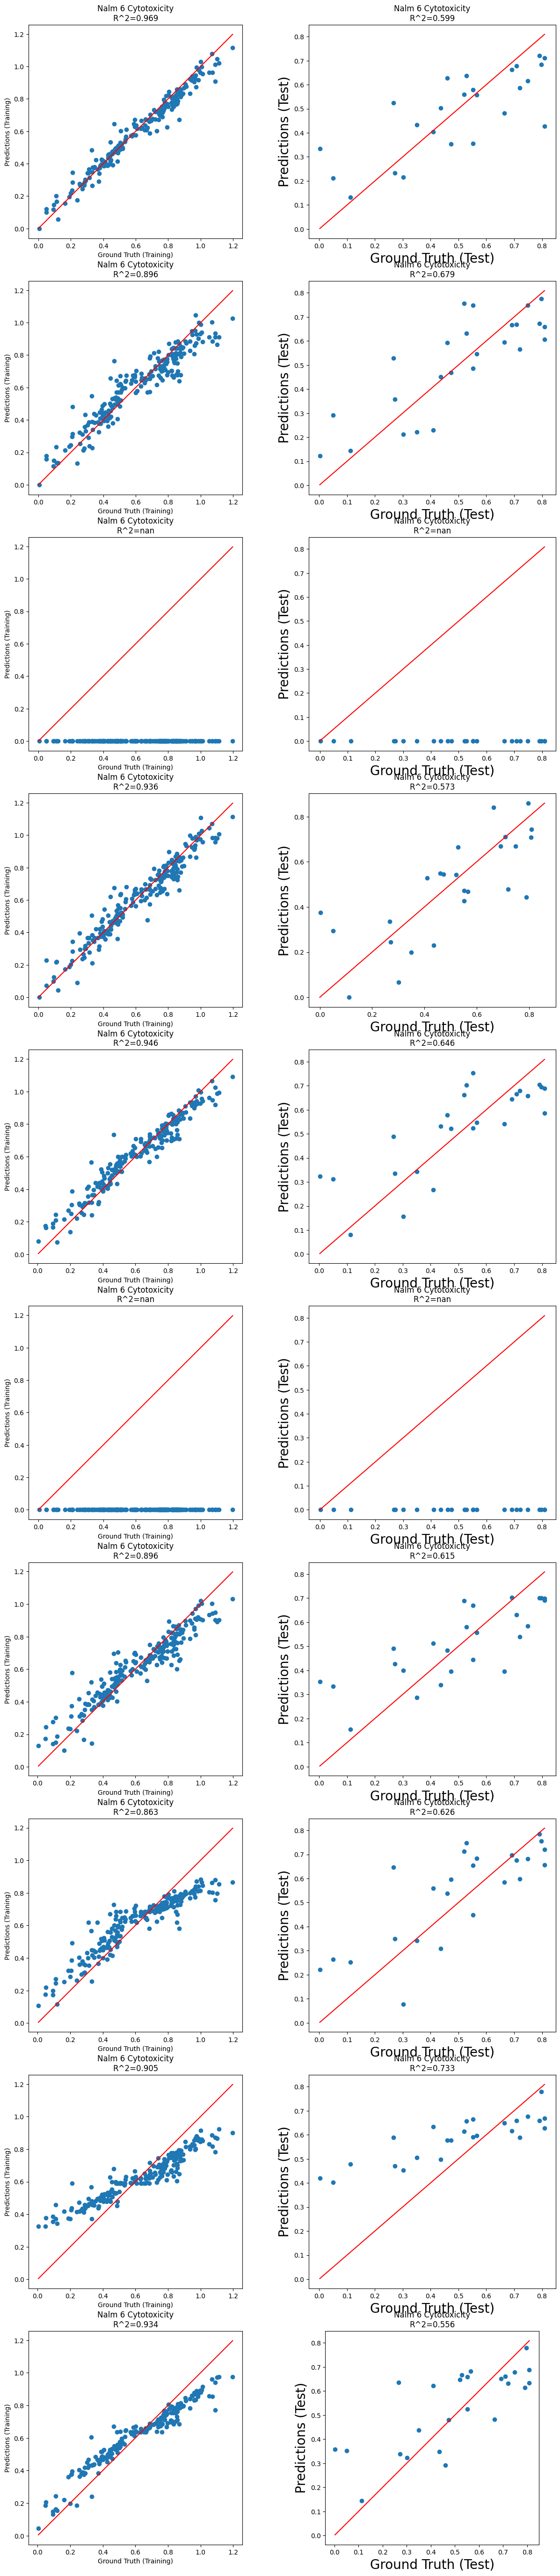

In [22]:
hyperparameter_set = [
    [20, 5, 4, 0., 64, ],
    [10, 2, 8, 0., 16, ],
    [20, 4, 8, 0.2, 4, ],
    [10, 2, 4, 0., 64, ],
    [20, 4, 2, 0., 16, ],
    [20, 2, 4, 0., 4, ],
    [10, 5, 4, 0., 16, ],
    [20, 5, 4, 0., 4, ],
    [20, 2, 4, 0., 4, ],
    [50, 5, 4, 0., 4, ],
]
tf.keras.utils.set_random_seed(3)
fig, axs = plt.subplots(len(hyperparameter_set), 2, figsize=[15,70])
for i, (filters, kernel_size, LSTM_units, dropout_rate, fc_nodes) in enumerate(hyperparameter_set):
    # Rerun the gbrt with the best combination of hyperparameters
    #large max_depth to prevent overfitting
    model_LSTM_best = KerasRegressor(build_fn=create_model, filters=filters, LSTM_units=LSTM_units, dropout_rate1=dropout_rate, fc_nodes=fc_nodes)
    model_LSTM_best.fit(combine_input_train, Y_train, batch_size=batch_size,  epochs=1200, verbose=0)
    pred_train = model_LSTM_best.predict(combine_input_train)*max_y
    pred_test = model_LSTM_best.predict(combine_input_test)*max_y
    r_squared_train, r_squared_test = do_plot(axs[i], pred_train, pred_test)
    print(i+1, filters, kernel_size, LSTM_units, dropout_rate, fc_nodes, '{:.3f}'.format(r_squared_train), '{:.3f}'.format(r_squared_test))
    model_LSTM_best.model.save(f'saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_Cytotoxicity_{i+1}.h5')